# Section 1: Initial setup, import and cleanup data

### 1a: Import all libraries and install packages needed for this analysis

In [1]:
# import all libraries and install packages upfront so we can efficiently rerun the rest of the code and tweak it as often as needed
import numpy as np 
import pandas as pd 

!conda install -c conda-forge lxml --yes
!conda install -c conda-forge geopy --yes

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!pip install folium
import folium 

print('All libraries imported.')

Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: failed with repodata from current_repodata.json, will retry with next repodata source.
Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: | 
Found conflicts! Looking for incompatible packages.
This can take several minutes.  Press CTRL-C to abort.
                                                                                                                                        |failed

UnsatisfiableError: The following specifications were found
to be incompatible with the existing python installation in your environment:

Specifications:

  - cffi -> python[version='2.7.*|3.5.*|3.6.*|3.6.12|3.6.12|>=3.6,<3.7.0a0|>=3.7,<3.8.0a0|>=3.9,<3.10.0a0|>=3.8,<3.9.0a0|3.7.9|3.6.9|3.6.9|3.6.9|>=2.7,<2.8.0a0|3.6.9|>=3.5,<3.6.0a0|3.4.*',build='2_73_pypy|4_73_pypy|5_73_pypy|3_73_pypy|1_73_pypy|0_73_pypy']
  - rsa -> python[version='2.7.*|

In [2]:
# check if all pckages are installed
import pkg_resources

for package in ['pandas', 'numpy', 'folium', 'geopy', 'matplotlib', 'lxml', 'requests', 'json', 'json_normalize']:
    try:
        dist = pkg_resources.get_distribution(package)
        print('>> {} ({}) is installed.'.format(dist.key, dist.version))
    except pkg_resources.DistributionNotFound:
        print('?? {} is NOT installed.'.format(package))

>> pandas (1.0.5) is installed.
>> numpy (1.18.5) is installed.
>> folium (0.12.1) is installed.
>> geopy (2.0.0) is installed.
>> matplotlib (3.2.2) is installed.
>> lxml (4.5.1) is installed.
>> requests (2.24.0) is installed.
?? json is NOT installed.
?? json_normalize is NOT installed.


### 1b: Import and cleanup data

In [3]:
# import list of all cities in CA with income data
df1 = pd.read_html('https://en.wikipedia.org/wiki/List_of_California_locations_by_income')[2]

# import list of cities with crime stats
df2 = pd.read_html('https://en.wikipedia.org/wiki/California_locations_by_crime_rate')[2]

In [4]:
# Make sure data is imported correctly
df1.head()

Place County/ies[note 2]  Population[1]  \
0  Acalanes Ridge       Contra Costa           1226   
1          Acampo        San Joaquin            776   
2           Acton        Los Angeles           6956   
3        Adelanto     San Bernardino          31773   
4            Adin              Modoc            215   

   Populationdensity[1][2][note 1] Per capita income[3]  \
0                           2659.4              $62,314   
1                            827.3              $36,756   
2                            177.2              $39,131   
3                            567.3               $9,998   
4                             62.6              $15,452   

  Median household income[6] Median family income[5]  
0                   $160,000                $190,104  
1                   $141,250                     [7]  
2                    $92,245                 $99,448  
3                    $35,262                 $35,537  
4                    $29,583                 $60,083

In [5]:
df2.head()

City/Agency          County  Population[5]  \
0      Adelanto  San Bernardino          31213   
1  Agoura Hills     Los Angeles          20767   
2       Alameda         Alameda          77048   
3        Albany         Alameda          19350   
4      Alhambra     Los Angeles          84931   

   Populationdensity[5][3][note 2]  Violent crimes[5]  \
0                            557.3                189   
1                           2664.8                 17   
2                           7378.7                145   
3                          10822.1                 31   
4                          11129.7                168   

   Violent crime rateper 1,000 persons  Property crimes[5]  \
0                                 6.06                 790   
1                                 0.82                 234   
2                                 1.88                1723   
3                                 1.60                 478   
4                                 1.98                1743   

   Property crime rateper 1,000 persons  
0                                 25.31  
1                                 11.27  
2                                 22.36  
3                                 24.70  
4                                 20.52

In [6]:
# rename column names for easy reference
df1.columns = ['City','County','Population','PopDensity','PerCapitaIncome','MedianIncome','FamilyIncome']
df2.columns = ['City','County','Population','PopDensity','VCrimes','VCrimesPer1000','PCrimes','PCrimesPer1000']

In [7]:
# we're only interested in cities in LA county, so remove rows for all other counties
df1.drop(df1[df1['County'] != 'Los Angeles'].index, inplace = True) 
df2.drop(df2[df2['County'] != 'Los Angeles'].index, inplace = True) 

In [8]:
# convert column MediaIncome data type from object to string
df1["MedianIncome"] = df1["MedianIncome"].astype(str)

# remove nonnumeric characters
df1['MedianIncome'] = df1['MedianIncome'].str.replace('$', '')
df1['MedianIncome'] = df1['MedianIncome'].str.replace(',','')

In [9]:
# now convert back to float
df1['MedianIncome'] = df1['MedianIncome'].astype(float)

In [10]:
# we'r only interested in cities with median income greater than $50,000
df1.drop(df1[df1['MedianIncome'] <=50000].index, inplace = True) 

# we will analyze cties with less than 5 violent crimes per 1000 population
df2.drop(df2[df2['VCrimesPer1000'] > 5].index, inplace = True) 

In [11]:
# remove all columns not required for our analysis
df2.drop(['County','Population','PopDensity'], axis=1, inplace=True)

In [12]:
# Let's make sure our surce data looks good
df1.head()

City       County  Population  PopDensity PerCapitaIncome  \
2          Acton  Los Angeles        6956       177.2         $39,131   
5   Agoura Hills  Los Angeles       20630      2647.2         $50,242   
6     Agua Dulce  Los Angeles        2898       126.8         $37,538   
15      Alhambra  Los Angeles       84400     11060.1         $24,971   
22  Alondra Park  Los Angeles        8833      7979.2         $21,583   

    MedianIncome FamilyIncome  
2        92245.0      $99,448  
5       107268.0     $118,673  
6        88864.0     $102,989  
15       53195.0      $57,056  
22       55263.0      $57,944

In [13]:
df2.head()

City  VCrimes  VCrimesPer1000  PCrimes  PCrimesPer1000
1   Agoura Hills       17            0.82      234           11.27
4       Alhambra      168            1.98     1743           20.52
13       Arcadia       60            1.04     1159           20.00
16       Artesia       49            2.92      294           17.51
24         Azusa      165            3.42     1065           22.08

### 1c: Merge the 2 wikipedia imports to create one dataframe with cities, income and crime stats

In [14]:
df1.set_index('City')
df2.set_index('City')
df = pd.merge(left=df1, right=df2, how='left', left_on='City', right_on='City')
df.head()

City       County  Population  PopDensity PerCapitaIncome  \
0         Acton  Los Angeles        6956       177.2         $39,131   
1  Agoura Hills  Los Angeles       20630      2647.2         $50,242   
2    Agua Dulce  Los Angeles        2898       126.8         $37,538   
3      Alhambra  Los Angeles       84400     11060.1         $24,971   
4  Alondra Park  Los Angeles        8833      7979.2         $21,583   

   MedianIncome FamilyIncome  VCrimes  VCrimesPer1000  PCrimes  PCrimesPer1000  
0       92245.0      $99,448      NaN             NaN      NaN             NaN  
1      107268.0     $118,673     17.0            0.82    234.0           11.27  
2       88864.0     $102,989      NaN             NaN      NaN             NaN  
3       53195.0      $57,056    168.0            1.98   1743.0           20.52  
4       55263.0      $57,944      NaN             NaN      NaN             NaN

In [15]:
# remove rows having columns with no data 
df.dropna(inplace=True)

### Use GeoLocator to find coordinates

In [16]:
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values
geolocator = Nominatim(user_agent="HTTP")

df['Major_Dist_Coord']= df['City'].apply(geolocator.geocode).apply(lambda x: (x.latitude, x.longitude))
df[['Latitude', 'Longitude']] = df['Major_Dist_Coord'].apply(pd.Series)

df.drop(['Major_Dist_Coord'], axis=1, inplace=True)
df.head()

City       County  Population  PopDensity PerCapitaIncome  \
1   Agoura Hills  Los Angeles       20630      2647.2         $50,242   
3       Alhambra  Los Angeles       84400     11060.1         $24,971   
6        Arcadia  Los Angeles       57251      5240.4         $38,582   
7        Artesia  Los Angeles       16698     10301.0         $21,688   
10         Azusa  Los Angeles       47420      4910.9         $18,159   

    MedianIncome FamilyIncome  VCrimes  VCrimesPer1000  PCrimes  \
1       107268.0     $118,673     17.0            0.82    234.0   
3        53195.0      $57,056    168.0            1.98   1743.0   
6        80147.0      $93,635     60.0            1.04   1159.0   
7        60544.0      $62,485     49.0            2.92    294.0   
10       52087.0      $57,131    165.0            3.42   1065.0   

    PCrimesPer1000   Latitude   Longitude  
1            11.27  34.147910 -118.765704  
3            20.52  37.176060   -3.588110  
6            20.00  34.136207 -118.040150  
7            17.51  33.869020 -118.079620  
10           22.08  34.133875 -117.905605

# Section 2: Build clusters of neighborhoods in LA county

### 2a: Get geographical coordinates of Los angeles as the center of our map

In [17]:
address = 'Los Angeles'

geolocator = Nominatim(user_agent="Los_Angeles")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Los Angeles are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Los Angeles are 34.0536909, -118.242766.


### 2b: Use Folium to visualize cities in LA county

In [18]:
# create map of Cologne using latitude and longitude 
LA = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to the map
for lat, lng, label in zip(df['Latitude'], df['Longitude'], df['City']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(LA) 
    
LA

### 2c: Use Foursquare API to explore and segment the neighborhoods

In [19]:
# The code was removed by Watson Studio for sharing.

In [20]:
# Show top 25 venues in a radius of 10 miles (approx 16000 meters)
LIMIT = 50

radius = 32000

url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    Client_Id, 
    Client_Secret, 
    Version, 
    lat,
    lng,
    radius, 
    LIMIT)
url 

'https://api.foursquare.com/v2/venues/explore?&client_id=MMYM2FFTDBU21QQNVLMOCTSR4TGIN0GUD1Q5F43UH22BID54&client_secret=QZHCEF2EZTBU0EYGQTIX0QFSOK0SO4YO5R3NJEFMAKPKJ01R&v=20180605&ll=33.9708782,-118.0308396&radius=32000&limit=50'

In [21]:
results = requests.get(url).json()

In [22]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [23]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:3: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  app.launch_new_instance()


name            categories        lat         lng
0                 Liquor Mart          Liquor Store  33.961412 -118.029345
1                  Pizzamania           Pizza Place  33.937762 -118.042097
2                      Costco       Warehouse Store  33.933055 -117.969551
3  Northgate Gonzalez Markets                Market  33.940191 -117.960459
4             In-N-Out Burger  Fast Food Restaurant  33.936074 -118.124260

In [24]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

50 venues were returned by Foursquare.


In [25]:
print ('{} unique categories in LA County.'.format(nearby_venues['categories'].value_counts().shape[0]))

32 unique categories in LA County.


In [26]:
print (nearby_venues['categories'].value_counts()[0:25])

Fast Food Restaurant    5
Pizza Place             3
Liquor Store            3
Garden                  3
Grocery Store           2
Theme Park              2
Sandwich Place          2
Bakery                  2
Park                    2
Brewery                 2
Coffee Shop             2
Art Gallery             2
Climbing Gym            1
Sporting Goods Shop     1
Big Box Store           1
Cuban Restaurant        1
Wine Shop               1
Mexican Restaurant      1
Market                  1
Frozen Yogurt Shop      1
Clothing Store          1
Museum                  1
Italian Restaurant      1
Trail                   1
Home Service            1
Name: categories, dtype: int64


### 2d: Explore the neighbourhoods around LA

In [27]:
def getNearbyVenues(names, latitudes, longitudes, radius=3000, LIMIT=1000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            Client_Id, 
            Client_Secret, 
            Version, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']

    
    return(nearby_venues)

In [29]:
LA_venues = getNearbyVenues(names=df['City'],
                                   latitudes=df['Latitude'],
                                   longitudes=df['Longitude']
                                  )
LA_venues.head()

Agoura Hills
Alhambra
Arcadia
Artesia
Azusa
Baldwin Park
Beverly Hills
Bradbury
Burbank
Calabasas
Carson
Cerritos
Claremont
Covina
Culver City
Diamond Bar
Downey
Duarte
El Segundo
Glendale
Glendora
Hermosa Beach
Hidden Hills
La Cañada Flintridge
La Habra Heights
Lakewood
La Mirada
La Puente
La Verne
Lomita
Long Beach
Malibu
Manhattan Beach
Monrovia
Monterey Park
Norwalk
Palos Verdes Estates
Pasadena
Pico Rivera
Rancho Palos Verdes
Redondo Beach
Rolling Hills
Rolling Hills Estates
San Dimas
San Fernando
San Gabriel
San Marino
Santa Clarita
Santa Fe Springs
Santa Monica
Sierra Madre
Signal Hill
South Pasadena
Temple City
Torrance
Walnut
West Covina
Westlake Village
Whittier


Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0  Agoura Hills               34.14791             -118.765704   
1  Agoura Hills               34.14791             -118.765704   
2  Agoura Hills               34.14791             -118.765704   
3  Agoura Hills               34.14791             -118.765704   
4  Agoura Hills               34.14791             -118.765704   

                     Venue  Venue Latitude  Venue Longitude  \
0            El Pollo Loco       34.144732      -118.761088   
1     Italia Deli & Bakery       34.153099      -118.759037   
2             Trader Joe's       34.146241      -118.756609   
3  Tifa Chocolate & Gelato       34.144586      -118.754595   
4   Wood Ranch BBQ & Grill       34.144711      -118.755350   

         Venue Category  
0  Fast Food Restaurant  
1         Deli / Bodega  
2         Grocery Store  
3          Dessert Shop  
4             BBQ Joint

In [30]:
LA_venues.shape

(5142, 7)

In [31]:
# Create a Data-Frame out of it to concentrate only on Restaurants 
LA_Venues_only_restaurant = LA_venues[LA_venues['Venue Category'].str.contains('Restaurant')].reset_index(drop=True)
LA_Venues_only_restaurant.index = np.arange(1, len(LA_Venues_only_restaurant )+1)

In [32]:
print (LA_Venues_only_restaurant['Venue Category'].value_counts())

Mexican Restaurant                 249
American Restaurant                146
Fast Food Restaurant               143
Italian Restaurant                 120
Chinese Restaurant                  93
Sushi Restaurant                    81
Seafood Restaurant                  79
Japanese Restaurant                 65
Restaurant                          52
Asian Restaurant                    51
Thai Restaurant                     50
Mediterranean Restaurant            45
Vietnamese Restaurant               40
Indian Restaurant                   37
Korean Restaurant                   32
New American Restaurant             32
Vegetarian / Vegan Restaurant       27
Spanish Restaurant                  19
Tapas Restaurant                    14
Middle Eastern Restaurant           12
French Restaurant                   11
Greek Restaurant                    11
Dumpling Restaurant                  9
Peruvian Restaurant                  9
Latin American Restaurant            8
Tex-Mex Restaurant       

In [33]:
print('There are {} unique categories.'.format(len(LA_Venues_only_restaurant['Venue Category'].unique())))

There are 55 unique categories.


In [34]:
# create a dataframe of top 10 categories
LA_Venues_Top15 = LA_Venues_only_restaurant['Venue Category'].value_counts()[0:15].to_frame(name='frequency')
LA_Venues_Top15 = LA_Venues_Top15.reset_index()
LA_Venues_Top15.rename(index=str, columns={"index": "Venue_Category", "frequency": "Frequency"}, inplace=True)
LA_Venues_Top15

Venue_Category  Frequency
0         Mexican Restaurant        249
1        American Restaurant        146
2       Fast Food Restaurant        143
3         Italian Restaurant        120
4         Chinese Restaurant         93
5           Sushi Restaurant         81
6         Seafood Restaurant         79
7        Japanese Restaurant         65
8                 Restaurant         52
9           Asian Restaurant         51
10           Thai Restaurant         50
11  Mediterranean Restaurant         45
12     Vietnamese Restaurant         40
13         Indian Restaurant         37
14         Korean Restaurant         32

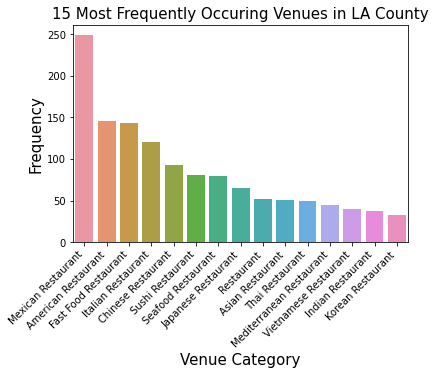

<Figure size 1296x504 with 0 Axes>

In [35]:
import seaborn as sns
from matplotlib import pyplot as plt

s=sns.barplot(x="Venue_Category", y="Frequency", data=LA_Venues_Top15)
s.set_xticklabels(s.get_xticklabels(), rotation=45, horizontalalignment='right')

plt.title('15 Most Frequently Occuring Venues in LA County', fontsize=15)
plt.xlabel("Venue Category", fontsize=15)
plt.ylabel ("Frequency", fontsize=15)
plt.savefig("Most_Freq_Venues1.png", dpi=300)
fig = plt.figure(figsize=(18,7))
plt.show()

In [36]:
# F: Size of the dataframe that results.

In [37]:
print ("Shape of the Data-Frame with Venue Category only Restaurant: ", LA_Venues_only_restaurant.shape)
LA_Venues_only_restaurant.head(75)

Shape of the Data-Frame with Venue Category only Restaurant:  (1522, 7)


Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
1   Agoura Hills              34.147910             -118.765704   
2   Agoura Hills              34.147910             -118.765704   
3   Agoura Hills              34.147910             -118.765704   
4   Agoura Hills              34.147910             -118.765704   
5   Agoura Hills              34.147910             -118.765704   
6   Agoura Hills              34.147910             -118.765704   
7   Agoura Hills              34.147910             -118.765704   
8   Agoura Hills              34.147910             -118.765704   
9   Agoura Hills              34.147910             -118.765704   
10  Agoura Hills              34.147910             -118.765704   
11  Agoura Hills              34.147910             -118.765704   
12  Agoura Hills              34.147910             -118.765704   
13  Agoura Hills              34.147910             -118.765704   
14  Agoura Hills              34.147910             -118.765704   
15  Agoura Hills              34.147910             -118.765704   
16  Agoura Hills              34.147910             -118.765704   
17  Agoura Hills              34.147910             -118.765704   
18  Agoura Hills              34.147910             -118.765704   
19  Agoura Hills              34.147910             -118.765704   
20  Agoura Hills              34.147910             -118.765704   
21  Agoura Hills              34.147910             -118.765704   
22  Agoura Hills              34.147910             -118.765704   
23  Agoura Hills              34.147910             -118.765704   
24  Agoura Hills              34.147910             -118.765704   
25  Agoura Hills              34.147910             -118.765704   
26  Agoura Hills              34.147910             -118.765704   
27  Agoura Hills              34.147910             -118.765704   
28  Agoura Hills              34.147910             -118.765704   
29  Agoura Hills              34.147910             -118.765704   
30  Agoura Hills              34.147910             -118.765704   
31  Agoura Hills              34.147910             -118.765704   
32  Agoura Hills              34.147910             -118.765704   
33      Alhambra              37.176060               -3.588110   
34      Alhambra              37.176060               -3.588110   
35      Alhambra              37.176060               -3.588110   
36      Alhambra              37.176060               -3.588110   
37      Alhambra              37.176060               -3.588110   
38      Alhambra              37.176060               -3.588110   
39      Alhambra              37.176060               -3.588110   
40      Alhambra              37.176060               -3.588110   
41      Alhambra              37.176060               -3.588110   
42      Alhambra              37.176060               -3.588110   
43      Alhambra              37.176060               -3.588110   
44      Alhambra              37.176060               -3.588110   
45      Alhambra              37.176060               -3.588110   
46      Alhambra              37.176060               -3.588110   
47      Alhambra              37.176060               -3.588110   
48      Alhambra              37.176060               -3.588110   
49      Alhambra              37.176060               -3.588110   
50      Alhambra              37.176060               -3.588110   
51      Alhambra              37.176060               -3.588110   
52      Alhambra              37.176060               -3.588110   
53      Alhambra              37.176060               -3.588110   
54      Alhambra              37.176060               -3.588110   
55      Alhambra              37.176060               -3.588110   
56      Alhambra              37.176060               -3.588110   
57      Alhambra              37.176060               -3.588110   
58      Alhambra              37.176060               -3.588110   
59      Alhambra              37.176060            

In [38]:
LA_Venues_restaurant = LA_Venues_only_restaurant.groupby(['Neighborhood'])['Venue Category'].apply(lambda x: x[x.str.contains('Restaurant')].count())

In [39]:
# G: Analysis of the neighbourhoods.

In [40]:
LA_Venues_restaurant

Neighborhood
Agoura Hills             32
Alhambra                 32
Arcadia                  22
Artesia                  41
Azusa                    21
Baldwin Park             24
Beverly Hills            26
Bradbury                 32
Burbank                  23
Calabasas                 9
Cerritos                 37
Claremont                29
Covina                   34
Culver City              22
Diamond Bar              28
Downey                   31
El Segundo               22
Glendale                 33
Glendora                 26
Hermosa Beach            39
Hidden Hills             13
La Cañada Flintridge     31
La Habra Heights         13
La Mirada                28
La Puente                20
La Verne                 25
Lakewood                 25
Lomita                   37
Long Beach               31
Malibu                   19
Manhattan Beach          27
Monrovia                  2
Monterey Park            52
Norwalk                  34
Palos Verdes Estates      6
Pasaden

In [41]:
LA_Venues_restaurant_df  = LA_Venues_restaurant.to_frame().reset_index()
LA_Venues_restaurant_df.columns = ['Neighborhood', 'Number of Restaurant']
LA_Venues_restaurant_df.index = np.arange(1, len(LA_Venues_restaurant_df)+1)
list_rest_no =LA_Venues_restaurant_df['Number of Restaurant'].to_list()
list_dist =LA_Venues_restaurant_df['Neighborhood'].to_list()

In [43]:
# one hot encoding
LA_onehot = pd.get_dummies(LA_Venues_only_restaurant[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
LA_onehot['Neighborhood'] = LA_Venues_only_restaurant['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [LA_onehot.columns[-1]] + list(LA_onehot.columns[:-1])
LA_onehot = LA_onehot[fixed_columns]

LA_onehot
#--.head()

Neighborhood  American Restaurant  Andhra Restaurant  \
1              Agoura Hills                    0                  0   
2              Agoura Hills                    0                  0   
3              Agoura Hills                    0                  0   
4              Agoura Hills                    0                  0   
5              Agoura Hills                    0                  0   
6              Agoura Hills                    1                  0   
7              Agoura Hills                    0                  0   
8              Agoura Hills                    0                  0   
9              Agoura Hills                    0                  0   
10             Agoura Hills                    0                  0   
11             Agoura Hills                    0                  0   
12             Agoura Hills                    0                  0   
13             Agoura Hills                    0                  0   
14             Agoura Hills                    0                  0   
15             Agoura Hills                    0                  0   
16             Agoura Hills                    0                  0   
17             Agoura Hills                    0                  0   
18             Agoura Hills                    0                  0   
19             Agoura Hills                    0                  0   
20             Agoura Hills                    0                  0   
21             Agoura Hills                    0                  0   
22             Agoura Hills                    0                  0   
23             Agoura Hills                    0                  0   
24             Agoura Hills                    0                  0   
25             Agoura Hills                    0                  0   
26             Agoura Hills                    0                  0   
27             Agoura Hills                    0                  0   
28             Agoura Hills                    0                  0   
29             Agoura Hills                    0                  0   
30             Agoura Hills                    0                  0   
31             Agoura Hills                    0                  0   
32             Agoura Hills                    0                  0   
33                 Alhambra                    0                  0   
34                 Alhambra                    0                  0   
35                 Alhambra                    0                  0   
36                 Alhambra                    0                  0   
37                 Alhambra                    0                  0   
38                 Alhambra                    0                  0   
39                 Alhambra                    0                  0   
40                 Alhambra                    0                  0   
41                 Alhambra                    0                  0   
42                 Alhambra                    0                  0   
43                 Alhambra                    0                  0   
44                 Alhambra                    0                  0   
45                 Alhambra                    0                  0   
46                 Alhambra                    0                  0   
47                 Alhambra                    0                  0   
48                 Alhambra                    0                  0   
49                 Alhambra                    0                  0   
50                 Alhambra                    0                  0   
51                 Alhambra                    0                  0   
52                 Alhambra                    0                  0   
53                 Alhambra                    0                  0   
54                 Alhambra                    0                  0   
55                 Alhambra                    0                  0   
56                 Alhambra            

In [44]:
LA_onehot

Neighborhood  American Restaurant  Andhra Restaurant  \
1              Agoura Hills                    0                  0   
2              Agoura Hills                    0                  0   
3              Agoura Hills                    0                  0   
4              Agoura Hills                    0                  0   
5              Agoura Hills                    0                  0   
6              Agoura Hills                    1                  0   
7              Agoura Hills                    0                  0   
8              Agoura Hills                    0                  0   
9              Agoura Hills                    0                  0   
10             Agoura Hills                    0                  0   
11             Agoura Hills                    0                  0   
12             Agoura Hills                    0                  0   
13             Agoura Hills                    0                  0   
14             Agoura Hills                    0                  0   
15             Agoura Hills                    0                  0   
16             Agoura Hills                    0                  0   
17             Agoura Hills                    0                  0   
18             Agoura Hills                    0                  0   
19             Agoura Hills                    0                  0   
20             Agoura Hills                    0                  0   
21             Agoura Hills                    0                  0   
22             Agoura Hills                    0                  0   
23             Agoura Hills                    0                  0   
24             Agoura Hills                    0                  0   
25             Agoura Hills                    0                  0   
26             Agoura Hills                    0                  0   
27             Agoura Hills                    0                  0   
28             Agoura Hills                    0                  0   
29             Agoura Hills                    0                  0   
30             Agoura Hills                    0                  0   
31             Agoura Hills                    0                  0   
32             Agoura Hills                    0                  0   
33                 Alhambra                    0                  0   
34                 Alhambra                    0                  0   
35                 Alhambra                    0                  0   
36                 Alhambra                    0                  0   
37                 Alhambra                    0                  0   
38                 Alhambra                    0                  0   
39                 Alhambra                    0                  0   
40                 Alhambra                    0                  0   
41                 Alhambra                    0                  0   
42                 Alhambra                    0                  0   
43                 Alhambra                    0                  0   
44                 Alhambra                    0                  0   
45                 Alhambra                    0                  0   
46                 Alhambra                    0                  0   
47                 Alhambra                    0                  0   
48                 Alhambra                    0                  0   
49                 Alhambra                    0                  0   
50                 Alhambra                    0                  0   
51                 Alhambra                    0                  0   
52                 Alhambra                    0                  0   
53                 Alhambra                    0                  0   
54                 Alhambra                    0                  0   
55                 Alhambra                    0                  0   
56                 Alhambra            

In [45]:
# New dataframe size.
LA_onehot.shape

(1522, 56)

In [46]:
# H: Grouping by neighbourhoods and showing the mean of the frequency of occurrence for each category of restaurants.

In [47]:
LA_grouped = LA_onehot.groupby('Neighborhood').mean().reset_index()
LA_grouped.head()

Neighborhood  American Restaurant  Andhra Restaurant  \
0  Agoura Hills             0.031250                0.0   
1      Alhambra             0.031250                0.0   
2       Arcadia             0.090909                0.0   
3       Artesia             0.048780                0.0   
4         Azusa             0.238095                0.0   

   Argentinian Restaurant  Asian Restaurant  Australian Restaurant  \
0                     0.0          0.031250                    0.0   
1                     0.0          0.000000                    0.0   
2                     0.0          0.045455                    0.0   
3                     0.0          0.048780                    0.0   
4                     0.0          0.000000                    0.0   

   Brazilian Restaurant  Cajun / Creole Restaurant  Cambodian Restaurant  \
0                   0.0                        0.0                   0.0   
1                   0.0                        0.0                   0.0   
2                   0.0                        0.0                   0.0   
3                   0.0                        0.0                   0.0   
4                   0.0                        0.0                   0.0   

   Cantonese Restaurant  Caribbean Restaurant  Chinese Restaurant  \
0              0.000000                   0.0            0.093750   
1              0.000000                   0.0            0.000000   
2              0.045455                   0.0            0.090909   
3              0.000000                   0.0            0.073171   
4              0.000000                   0.0            0.047619   

   Comfort Food Restaurant  Cuban Restaurant  Dim Sum Restaurant  \
0                      0.0               0.0                 0.0   
1                      0.0               0.0                 0.0   
2                      0.0               0.0                 0.0   
3                      0.0               0.0                 0.0   
4                      0.0               0.0                 0.0   

   Dumpling Restaurant  Empanada Restaurant  Fast Food Restaurant  \
0             0.000000                  0.0              0.125000   
1             0.000000                  0.0              0.031250   
2             0.090909                  0.0              0.090909   
3             0.024390                  0.0              0.024390   
4             0.000000                  0.0              0.190476   

   Filipino Restaurant  French Restaurant  Gluten-free Restaurant  \
0              0.00000            0.03125                     0.0   
1              0.00000            0.00000                     0.0   
2              0.00000            0.00000                     0.0   
3              0.04878            0.00000                     0.0   
4              0.00000            0.00000                     0.0   

   Greek Restaurant  Hawaiian Restaurant  Hotpot Restaurant  \
0               0.0              0.00000           0.000000   
1               0.0              0.00000           0.000000   
2               0.0              0.00000           0.045455   
3               0.0              0.02439           0.024390   
4               0.0              0.00000           0.000000   

   Indian Chinese Restaurant  Indian Restaurant  Indonesian Restaurant  \
0                    0.03125           0.093750                    0.0   
1                    0.00000           0.000000                    0.0   
2                    0.00000           0.000000                    0.0   
3                    0.00000           0.170732                    0.0   
4                    0.00000           0.000000                    0.0   

   Italian Restaurant  Japanese Curry Restaurant  Japanese Restaurant  \
0            0.062500                        0.0              0.06250   
1            0.125000                        0.0              0.03125   
2            0.000000                        0.0              0.00000   


In [48]:
LA_grouped.shape

(57, 56)

In [49]:
num_top_venues = 10

for hood in LA_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = LA_grouped[LA_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Agoura Hills----
                       venue  freq
0         Mexican Restaurant  0.19
1       Fast Food Restaurant  0.12
2          Indian Restaurant  0.09
3         Chinese Restaurant  0.09
4        Japanese Restaurant  0.06
5         Italian Restaurant  0.06
6                 Restaurant  0.06
7         Seafood Restaurant  0.03
8  Middle Eastern Restaurant  0.03
9  Indian Chinese Restaurant  0.03


----Alhambra----
                      venue  freq
0        Spanish Restaurant  0.28
1                Restaurant  0.22
2          Tapas Restaurant  0.22
3        Italian Restaurant  0.12
4  Mediterranean Restaurant  0.03
5      Fast Food Restaurant  0.03
6        Seafood Restaurant  0.03
7       American Restaurant  0.03
8       Japanese Restaurant  0.03
9   New American Restaurant  0.00


----Arcadia----
                  venue  freq
0      Sushi Restaurant  0.14
1    Mexican Restaurant  0.14
2   American Restaurant  0.09
3  Fast Food Restaurant  0.09
4   Dumpling Restaurant  0.09
5  

In [50]:
# J: Creating a pandas dataframe.

In [51]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [52]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = LA_grouped['Neighborhood']

for ind in np.arange(LA_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(LA_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head(23)

Neighborhood 1st Most Common Venue     2nd Most Common Venue  \
0           Agoura Hills    Mexican Restaurant      Fast Food Restaurant   
1               Alhambra    Spanish Restaurant          Tapas Restaurant   
2                Arcadia    Mexican Restaurant          Sushi Restaurant   
3                Artesia     Indian Restaurant           Thai Restaurant   
4                  Azusa    Mexican Restaurant       American Restaurant   
5           Baldwin Park    Mexican Restaurant      Fast Food Restaurant   
6          Beverly Hills   American Restaurant        Italian Restaurant   
7               Bradbury    Mexican Restaurant      Fast Food Restaurant   
8                Burbank   American Restaurant        Mexican Restaurant   
9              Calabasas    Italian Restaurant          Sushi Restaurant   
10              Cerritos     Indian Restaurant        Mexican Restaurant   
11             Claremont   American Restaurant        Mexican Restaurant   
12                Covina    Mexican Restaurant       American Restaurant   
13           Culver City      Sushi Restaurant   New American Restaurant   
14           Diamond Bar  Fast Food Restaurant        Chinese Restaurant   
15                Downey    Mexican Restaurant       American Restaurant   
16            El Segundo    Mexican Restaurant        Italian Restaurant   
17              Glendale   Japanese Restaurant  Mediterranean Restaurant   
18              Glendora   American Restaurant        Mexican Restaurant   
19         Hermosa Beach    Mexican Restaurant        Italian Restaurant   
20          Hidden Hills  Fast Food Restaurant          Sushi Restaurant   
21  La Cañada Flintridge    Italian Restaurant        Mexican Restaurant   
22      La Habra Heights    Mexican Restaurant      Fast Food Restaurant   

        3rd Most Common Venue            4th Most Common Venue  \
0          Chinese Restaurant                Indian Restaurant   
1                  Restaurant               Italian Restaurant   
2         American Restaurant             Fast Food Restaurant   
3           Korean Restaurant               Chinese Restaurant   
4        Fast Food Restaurant                       Restaurant   
5          Italian Restaurant                 Asian Restaurant   
6    Mediterranean Restaurant                       Restaurant   
7          Italian Restaurant              American Restaurant   
8        Fast Food Restaurant                 Sushi Restaurant   
9          Seafood Restaurant             Fast Food Restaurant   
10        American Restaurant               Chinese Restaurant   
11       Fast Food Restaurant         Mediterranean Restaurant   
12       Fast Food Restaurant               Chinese Restaurant   
13         Mexican Restaurant            Indonesian Restaurant   
14      Vietnamese Restaurant               Mexican Restaurant   
15         Seafood Restaurant               Italian Restaurant   
16        American Restaurant             Fast Food Restaurant   
17  Middle Eastern Restaurant                 Asian Restaurant   
18       Fast Food Restaurant         Mediterranean Restaurant   
19        American Restaurant               Seafood Restaurant   
20         Seafood Restaurant              American Restaurant   
21        American Restaurant                 Sushi Restaurant   
22        American Restaurant  Southern / Soul Food Restaurant   

        5th Most Common Venue      6th Most Common Venue  \
0          Italian Restaurant                 Restaurant   
1          Seafood Restaurant       Fast Food Restaurant   
2         Dumpling Restaurant         Chinese Restaurant   
3          Italian Restaurant        American Restaurant   
4             Thai Restaurant         Italian Restaurant   
5   Latin American Restaurant        Hawaiian Restaurant   
6            Sushi Restaurant    New American Restaurant   
7             Thai Restaurant   Mediterranean Restaurant   
8    Mediterranean Restaurant  Middle Eastern Restaurant   
9 

### 2e: Cluster the neighbourhoods with k-means

In [53]:
# set number of clusters (I choose 5)
kclusters = 5

LA_grouped_clustering = LA_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(LA_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([1, 3, 1, 2, 1, 1, 3, 1, 1, 3], dtype=int32)

In [54]:
LA_merged = df
LA_merged.head(10)

City       County  Population  PopDensity PerCapitaIncome  \
1    Agoura Hills  Los Angeles       20630      2647.2         $50,242   
3        Alhambra  Los Angeles       84400     11060.1         $24,971   
6         Arcadia  Los Angeles       57251      5240.4         $38,582   
7         Artesia  Los Angeles       16698     10301.0         $21,688   
10          Azusa  Los Angeles       47420      4910.9         $18,159   
11   Baldwin Park  Los Angeles       76411     11523.3         $15,419   
12  Beverly Hills  Los Angeles       34536      6050.5         $81,788   
13       Bradbury  Los Angeles         845       431.8         $76,472   
14        Burbank  Los Angeles      104484      6025.3         $33,882   
15      Calabasas  Los Angeles       23956      1747.8         $60,703   

    MedianIncome FamilyIncome  VCrimes  VCrimesPer1000  PCrimes  \
1       107268.0     $118,673     17.0            0.82    234.0   
3        53195.0      $57,056    168.0            1.98   1743.0   
6        80147.0      $93,635     60.0            1.04   1159.0   
7        60544.0      $62,485     49.0            2.92    294.0   
10       52087.0      $57,131    165.0            3.42   1065.0   
11       51189.0      $51,599    219.0            2.85   1342.0   
12       87366.0     $123,636    111.0            3.19   1071.0   
13      112273.0     $116,667      2.0            1.85      9.0   
14       66111.0      $82,063    150.0            1.43   2426.0   
15      117176.0     $136,724     19.0            0.78    252.0   

    PCrimesPer1000   Latitude   Longitude  
1            11.27  34.147910 -118.765704  
3            20.52  37.176060   -3.588110  
6            20.00  34.136207 -118.040150  
7            17.51  33.869020 -118.079620  
10           22.08  34.133875 -117.905605  
11           17.44  34.085474 -117.961176  
12           30.79  34.069650 -118.396306  
13            8.30  34.146951 -117.970898  
14           23.10  34.181648 -118.325855  
15           10.36  34.144664 -118.644097

In [55]:
neighborhoods_venues_sorted.head(23)

Neighborhood 1st Most Common Venue     2nd Most Common Venue  \
0           Agoura Hills    Mexican Restaurant      Fast Food Restaurant   
1               Alhambra    Spanish Restaurant          Tapas Restaurant   
2                Arcadia    Mexican Restaurant          Sushi Restaurant   
3                Artesia     Indian Restaurant           Thai Restaurant   
4                  Azusa    Mexican Restaurant       American Restaurant   
5           Baldwin Park    Mexican Restaurant      Fast Food Restaurant   
6          Beverly Hills   American Restaurant        Italian Restaurant   
7               Bradbury    Mexican Restaurant      Fast Food Restaurant   
8                Burbank   American Restaurant        Mexican Restaurant   
9              Calabasas    Italian Restaurant          Sushi Restaurant   
10              Cerritos     Indian Restaurant        Mexican Restaurant   
11             Claremont   American Restaurant        Mexican Restaurant   
12                Covina    Mexican Restaurant       American Restaurant   
13           Culver City      Sushi Restaurant   New American Restaurant   
14           Diamond Bar  Fast Food Restaurant        Chinese Restaurant   
15                Downey    Mexican Restaurant       American Restaurant   
16            El Segundo    Mexican Restaurant        Italian Restaurant   
17              Glendale   Japanese Restaurant  Mediterranean Restaurant   
18              Glendora   American Restaurant        Mexican Restaurant   
19         Hermosa Beach    Mexican Restaurant        Italian Restaurant   
20          Hidden Hills  Fast Food Restaurant          Sushi Restaurant   
21  La Cañada Flintridge    Italian Restaurant        Mexican Restaurant   
22      La Habra Heights    Mexican Restaurant      Fast Food Restaurant   

        3rd Most Common Venue            4th Most Common Venue  \
0          Chinese Restaurant                Indian Restaurant   
1                  Restaurant               Italian Restaurant   
2         American Restaurant             Fast Food Restaurant   
3           Korean Restaurant               Chinese Restaurant   
4        Fast Food Restaurant                       Restaurant   
5          Italian Restaurant                 Asian Restaurant   
6    Mediterranean Restaurant                       Restaurant   
7          Italian Restaurant              American Restaurant   
8        Fast Food Restaurant                 Sushi Restaurant   
9          Seafood Restaurant             Fast Food Restaurant   
10        American Restaurant               Chinese Restaurant   
11       Fast Food Restaurant         Mediterranean Restaurant   
12       Fast Food Restaurant               Chinese Restaurant   
13         Mexican Restaurant            Indonesian Restaurant   
14      Vietnamese Restaurant               Mexican Restaurant   
15         Seafood Restaurant               Italian Restaurant   
16        American Restaurant             Fast Food Restaurant   
17  Middle Eastern Restaurant                 Asian Restaurant   
18       Fast Food Restaurant         Mediterranean Restaurant   
19        American Restaurant               Seafood Restaurant   
20         Seafood Restaurant              American Restaurant   
21        American Restaurant                 Sushi Restaurant   
22        American Restaurant  Southern / Soul Food Restaurant   

        5th Most Common Venue      6th Most Common Venue  \
0          Italian Restaurant                 Restaurant   
1          Seafood Restaurant       Fast Food Restaurant   
2         Dumpling Restaurant         Chinese Restaurant   
3          Italian Restaurant        American Restaurant   
4             Thai Restaurant         Italian Restaurant   
5   Latin American Restaurant        Hawaiian Restaurant   
6            Sushi Restaurant    New American Restaurant   
7             Thai Restaurant   Mediterranean Restaurant   
8    Mediterranean Restaurant  Middle Eastern Restaurant   
9 

In [56]:
neighborhoods_venues_sorted_w_clusters = neighborhoods_venues_sorted
neighborhoods_venues_sorted_w_clusters.head()

Neighborhood 1st Most Common Venue 2nd Most Common Venue  \
0  Agoura Hills    Mexican Restaurant  Fast Food Restaurant   
1      Alhambra    Spanish Restaurant      Tapas Restaurant   
2       Arcadia    Mexican Restaurant      Sushi Restaurant   
3       Artesia     Indian Restaurant       Thai Restaurant   
4         Azusa    Mexican Restaurant   American Restaurant   

  3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
0    Chinese Restaurant     Indian Restaurant    Italian Restaurant   
1            Restaurant    Italian Restaurant    Seafood Restaurant   
2   American Restaurant  Fast Food Restaurant   Dumpling Restaurant   
3     Korean Restaurant    Chinese Restaurant    Italian Restaurant   
4  Fast Food Restaurant            Restaurant       Thai Restaurant   

  6th Most Common Venue      7th Most Common Venue 8th Most Common Venue  \
0            Restaurant        Japanese Restaurant      Sushi Restaurant   
1  Fast Food Restaurant   Mediterranean Restaurant   American Restaurant   
2    Chinese Restaurant         Seafood Restaurant            Restaurant   
3   American Restaurant        Japanese Restaurant    Seafood Restaurant   
4    Italian Restaurant  Middle Eastern Restaurant    Chinese Restaurant   

      9th Most Common Venue     10th Most Common Venue  
0         French Restaurant  Middle Eastern Restaurant  
1       Japanese Restaurant         Dim Sum Restaurant  
2      Cantonese Restaurant          Hotpot Restaurant  
3  Mediterranean Restaurant        Filipino Restaurant  
4       Dumpling Restaurant          Hotpot Restaurant

In [57]:
# add clustering labels
neighborhoods_venues_sorted_w_clusters.insert(0, 'Cluster Labels', kmeans.labels_)

In [58]:
neighborhoods_venues_sorted_w_clusters.head()

Cluster Labels  Neighborhood 1st Most Common Venue 2nd Most Common Venue  \
0               1  Agoura Hills    Mexican Restaurant  Fast Food Restaurant   
1               3      Alhambra    Spanish Restaurant      Tapas Restaurant   
2               1       Arcadia    Mexican Restaurant      Sushi Restaurant   
3               2       Artesia     Indian Restaurant       Thai Restaurant   
4               1         Azusa    Mexican Restaurant   American Restaurant   

  3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
0    Chinese Restaurant     Indian Restaurant    Italian Restaurant   
1            Restaurant    Italian Restaurant    Seafood Restaurant   
2   American Restaurant  Fast Food Restaurant   Dumpling Restaurant   
3     Korean Restaurant    Chinese Restaurant    Italian Restaurant   
4  Fast Food Restaurant            Restaurant       Thai Restaurant   

  6th Most Common Venue      7th Most Common Venue 8th Most Common Venue  \
0            Restaurant        Japanese Restaurant      Sushi Restaurant   
1  Fast Food Restaurant   Mediterranean Restaurant   American Restaurant   
2    Chinese Restaurant         Seafood Restaurant            Restaurant   
3   American Restaurant        Japanese Restaurant    Seafood Restaurant   
4    Italian Restaurant  Middle Eastern Restaurant    Chinese Restaurant   

      9th Most Common Venue     10th Most Common Venue  
0         French Restaurant  Middle Eastern Restaurant  
1       Japanese Restaurant         Dim Sum Restaurant  
2      Cantonese Restaurant          Hotpot Restaurant  
3  Mediterranean Restaurant        Filipino Restaurant  
4       Dumpling Restaurant          Hotpot Restaurant

In [59]:
LA_merged.rename(columns={'City':'Neighborhood'}, inplace=True)

LA_merged = LA_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

LA_merged.head

<bound method NDFrame.head of               Neighborhood       County  Population  PopDensity  \
1             Agoura Hills  Los Angeles       20630      2647.2   
3                 Alhambra  Los Angeles       84400     11060.1   
6                  Arcadia  Los Angeles       57251      5240.4   
7                  Artesia  Los Angeles       16698     10301.0   
10                   Azusa  Los Angeles       47420      4910.9   
11            Baldwin Park  Los Angeles       76411     11523.3   
12           Beverly Hills  Los Angeles       34536      6050.5   
13                Bradbury  Los Angeles         845       431.8   
14                 Burbank  Los Angeles      104484      6025.3   
15               Calabasas  Los Angeles       23956      1747.8   
16                  Carson  Los Angeles       92475      4939.1   
18                Cerritos  Los Angeles       49599      5686.7   
21               Claremont  Los Angeles       35569      2664.3   
22                  Covina  Los 

### 2e: Visualize the resulting clusters

In [60]:
# create a map with folium
map_restaurants10 = folium.Map(location=[latitude,longitude], tiles='Restaurants', 
                               attr="<a href=https://github.com/python-visualization/folium/>Folium</a>")

# set color scheme for the five clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
for lat, lon, poi, cluster in zip(LA_merged['Latitude'], 
                                  LA_merged['Longitude'], 
                                  LA_merged['Neighborhood'], 
                                  LA_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    if poi == "Carson" or poi == "Duarte" :
        continue
    folium.CircleMarker(
        [lat, lon],
        radius=list_rest_no[list_dist.index(poi)]*0.5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_restaurants10)
       
map_restaurants10

In [61]:
# L: Examination of the 5 clusters.
# Now, we can examine each cluster and determine the discriminating venue categories that distinguish each cluster. 
# Based on the defining categories, we can then assign a name to each cluster.

In [67]:
# Cluster 1 
LA_merged.loc[LA_merged['Cluster Labels'] == 0, LA_merged.columns[[1] + list(range(5, LA_merged.shape[1]))]]

County  MedianIncome FamilyIncome  VCrimes  VCrimesPer1000  PCrimes  \
76  Los Angeles      119300.0     $154,050      5.0            0.37    221.0   

    PCrimesPer1000   Latitude  Longitude  Cluster Labels  \
76           16.53  43.945862  12.458306             0.0   

   1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue  \
76    Italian Restaurant            Restaurant   American Restaurant   

   4th Most Common Venue 5th Most Common Venue      6th Most Common Venue  \
76    Dim Sum Restaurant     Indian Restaurant  Indian Chinese Restaurant   

   7th Most Common Venue 8th Most Common Venue 9th Most Common Venue  \
76     Hotpot Restaurant   Hawaiian Restaurant      Greek Restaurant   

    10th Most Common Venue  
76  Gluten-free Restaurant

In [68]:
# Cluster 2 
LA_merged.loc[LA_merged['Cluster Labels'] == 1, LA_merged.columns[[1] + list(range(5, LA_merged.shape[1]))]]

County  MedianIncome FamilyIncome  VCrimes  VCrimesPer1000  PCrimes  \
1    Los Angeles      107268.0     $118,673     17.0            0.82    234.0   
6    Los Angeles       80147.0      $93,635     60.0            1.04   1159.0   
10   Los Angeles       52087.0      $57,131    165.0            3.42   1065.0   
11   Los Angeles       51189.0      $51,599    219.0            2.85   1342.0   
13   Los Angeles      112273.0     $116,667      2.0            1.85      9.0   
14   Los Angeles       66111.0      $82,063    150.0            1.43   2426.0   
21   Los Angeles       89648.0     $108,739     39.0            1.08    853.0   
22   Los Angeles       64496.0      $73,113    110.0            2.26   1108.0   
33   Los Angeles       84004.0     $103,205     48.0            2.83    538.0   
35   Los Angeles       74169.0      $82,961     66.0            1.29   1241.0   
40   Los Angeles      245694.0          [7]      0.0            0.00     12.0   
46   Los Angeles      111250.0     $113,833      8.0            1.47     49.0   
47   Los Angeles       79113.0      $88,660    202.0            2.48   1737.0   
48   Los Angeles       81178.0      $90,696     89.0            1.81    635.0   
49   Los Angeles       54660.0      $55,150    136.0            3.35    440.0   
50   Los Angeles       75662.0      $95,045     46.0            1.43    820.0   
53   Los Angeles       52944.0      $59,710   2304.0            4.89  12438.0   
63   Los Angeles      171328.0     $203,241      5.0            0.37    121.0   
65   Los Angeles       56576.0      $62,987    275.0            4.30   1360.0   
73   Los Angeles       78911.0      $92,140     69.0            2.03    631.0   
78   Los Angeles       83178.0      $90,819    307.0            1.48   2437.0   
79   Los Angeles       51786.0      $63,333     74.0            4.29   1124.0   
81   Los Angeles       90780.0     $111,389     13.0            1.17     92.0   
82   Los Angeles       67320.0      $65,851     40.0            3.51    500.0   
99   Los Angeles       67069.0      $72,751    225.0            2.08   2832.0   
104  Los Angeles       65583.0      $74,628    239.0            2.75   2247.0   

     PCrimesPer1000   Latitude   Longitude  Cluster Labels  \
1             11.27  34.147910 -118.765704             1.0   
6             20.00  34.136207 -118.040150             1.0   
10            22.08  34.133875 -117.905605             1.0   
11            17.44  34.085474 -117.961176             1.0   
13             8.30  34.146951 -117.970898             1.0   
14            23.10  34.181648 -118.325855             1.0   
21            23.67  34.096676 -117.719779             1.0   
22            22.76  34.087793 -117.889116             1.0   
33            31.67  33.917028 -118.415634             1.0   
35            24.19  34.136119 -117.865339             1.0   
40             6.27  34.164091 -118.657837             1.0   
46             8.99  33.960455 -117.950425             1.0   
47            21.34  39.708574 -105.084669             1.0   
48            12.89  33.906097 -118.010709             1.0   
49            10.84  34.019790 -117.950368             1.0   
50            25.57  34.100843 -117.767836             1.0   
53            26.40  33.769016 -118.191604             1.0   
63             8.85  33.787239 -118.401813             1.0   
65            21.26  33.983069 -118.096735             1.0   
73            18.58  34.106676 -117.806726             1.0   
78            11.78  34.391664 -118.542586             1.0   
79            65.14  33.948079 -118.069150             1.0   
81             8.30  34.161673 -118.052846             1.0   
82            43.82  33.804826 -118.168259             1.0   
99            26.19  34.068621 -117.938953             1.0   
104           25.84  33.970878 -118.030840             1.0   

    1st Most Common Venue  2nd Most Common Venue 3rd Most Common Venue  \
1      Mexican Restaurant   Fast Food Restaurant    Chinese Restaurant   

In [69]:
# Cluster 3 
LA_merged.loc[LA_merged['Cluster Labels'] == 2, LA_merged.columns[[1] + list(range(5, LA_merged.shape[1]))]]

County  MedianIncome FamilyIncome  VCrimes  VCrimesPer1000  PCrimes  \
7   Los Angeles       60544.0      $62,485     49.0            2.92    294.0   
18  Los Angeles       91487.0     $100,919     86.0            1.72   1525.0   
26  Los Angeles       90901.0      $95,500     49.0            0.86    722.0   
34  Los Angeles       52451.0      $61,806    186.0            0.94   3073.0   
52  Los Angeles       57245.0      $66,541     77.0            3.72    355.0   
59  Los Angeles       54821.0      $60,209     91.0            1.48   1039.0   
75  Los Angeles       56238.0      $62,144     83.0            2.05    555.0   
90  Los Angeles       63803.0      $73,210     45.0            1.24    428.0   
92  Los Angeles       78286.0      $94,077    155.0            1.05   2623.0   
97  Los Angeles      100934.0     $107,750     29.0            0.96    294.0   

    PCrimesPer1000   Latitude   Longitude  Cluster Labels  \
7            17.51  33.869020 -118.079620             2.0   
18           30.58  33.864429 -118.053932             2.0   
26           12.74  34.028623 -117.810337             2.0   
34           15.59  34.146942 -118.247847             2.0   
52           17.17  33.803655 -118.319501             2.0   
59           16.95  34.051522 -118.129807             2.0   
75           13.73  34.099073 -118.108568             2.0   
90           11.80  34.108299 -118.057757             2.0   
92           17.73  33.835849 -118.340629             2.0   
97            9.71  33.708588 -117.792610             2.0   

   1st Most Common Venue     2nd Most Common Venue      3rd Most Common Venue  \
7      Indian Restaurant           Thai Restaurant          Korean Restaurant   
18     Indian Restaurant        Mexican Restaurant        American Restaurant   
26  Fast Food Restaurant        Chinese Restaurant      Vietnamese Restaurant   
34   Japanese Restaurant  Mediterranean Restaurant  Middle Eastern Restaurant   
52   Japanese Restaurant        Mexican Restaurant           Sushi Restaurant   
59    Chinese Restaurant     Vietnamese Restaurant         Mexican Restaurant   
75    Chinese Restaurant     Vietnamese Restaurant         Seafood Restaurant   
90    Chinese Restaurant         Korean Restaurant         Mexican Restaurant   
92   Japanese Restaurant       American Restaurant           Asian Restaurant   
97     Korean Restaurant        Chinese Restaurant       Fast Food Restaurant   

    4th Most Common Venue 5th Most Common Venue    6th Most Common Venue  \
7      Chinese Restaurant    Italian Restaurant      American Restaurant   
18     Chinese Restaurant   Filipino Restaurant       Italian Restaurant   
26     Mexican Restaurant   Japanese Restaurant        Korean Restaurant   
34       Asian Restaurant      Ramen Restaurant     Fast Food Restaurant   
52      Korean Restaurant    Seafood Restaurant      Hawaiian Restaurant   
59       Asian Restaurant      Sushi Restaurant      Japanese Restaurant   
75      Korean Restaurant      Asian Restaurant     Fast Food Restaurant   
90  Vietnamese Restaurant  Fast Food Restaurant         Asian Restaurant   
92   Fast Food Restaurant     Korean Restaurant  New American Restaurant   
97     Mexican Restaurant    Seafood Restaurant        Indian Restaurant   

   7th Most Common Venue    8th Most Common Venue     9th Most Common Venue  \
7    Japanese Restaurant       Seafood Restaurant  Mediterranean Restaurant   
18      Asian Restaurant        Korean Restaurant      Fast Food Restaurant   
26   American Restaurant         Sushi Restaurant         Indian Restaurant   
34    Italian Restaurant       Seafood Restaurant     Vietnamese Restaurant   
52      Greek Restaurant         Asian Restaurant       Filipino Restaurant   
59       Thai Restaurant       Dim Sum Restaurant       Szechuan Restaurant   
75    Italian Restaurant       Mexican Restaurant       American Restaurant   
90    Italian Restaurant      American Restaurant       Szechuan Restaurant   
92            Re

In [70]:
# Cluster 4 - Fast food cluster
LA_merged.loc[LA_merged['Cluster Labels'] == 3, LA_merged.columns[[1] + list(range(5, LA_merged.shape[1]))]]

County  MedianIncome FamilyIncome  VCrimes  VCrimesPer1000  PCrimes  \
3    Los Angeles       53195.0      $57,056    168.0            1.98   1743.0   
12   Los Angeles       87366.0     $123,636    111.0            3.19   1071.0   
15   Los Angeles      117176.0     $136,724     19.0            0.78    252.0   
23   Los Angeles       79292.0      $99,860    169.0            4.27   1693.0   
27   Los Angeles       60374.0      $64,187    281.0            2.47   2897.0   
39   Los Angeles      105029.0     $167,750     37.0            1.86    543.0   
43   Los Angeles      151786.0     $169,482     18.0            0.87    306.0   
54   Los Angeles      130432.0     $169,241     25.0            1.94    312.0   
55   Los Angeles      142071.0     $177,532     37.0            1.03    878.0   
61   Los Angeles       60523.0      $63,688    316.0            2.96   2001.0   
64   Los Angeles       70845.0      $88,600    394.0            2.81   3469.0   
67   Los Angeles      120697.0     $137,506     24.0            0.56    472.0   
68   Los Angeles      103064.0     $123,561    158.0            2.32   1447.0   
69   Los Angeles      218583.0     $227,250      1.0            0.53     18.0   
70   Los Angeles      136477.0     $154,043      7.0            0.85    114.0   
74   Los Angeles       55044.0      $56,482     75.0            3.08    406.0   
80   Los Angeles       74534.0     $113,956    338.0            3.63   3026.0   
84   Los Angeles       80479.0     $107,015     30.0            1.15    475.0   
101  Los Angeles      115550.0     $145,106      7.0            0.83    173.0   

     PCrimesPer1000   Latitude   Longitude  Cluster Labels  \
3             20.52  37.176060   -3.588110             3.0   
12            30.79  34.069650 -118.396306             3.0   
15            10.36  34.144664 -118.644097             3.0   
23            42.79  34.021122 -118.396466             3.0   
27            25.50  33.942215 -118.123565             3.0   
39            27.32  33.864280 -118.395910             3.0   
43            14.83  34.199830 -118.200524             3.0   
54            24.16  34.035591 -118.689423             3.0   
55            24.48  33.891599 -118.395124             3.0   
61            18.73  41.117597  -73.407897             3.0   
64            24.71  34.147645 -118.144478             3.0   
67            11.07  33.748331 -118.370768             3.0   
68            21.26  33.845591 -118.388677             3.0   
69             9.49  33.766804 -118.349662             3.0   
70            13.85  33.787794 -118.358128             3.0   
74            16.67  36.464393   -6.198203             3.0   
80            32.48  34.019470 -118.491227             3.0   
84            18.24  34.113306 -118.147829             3.0   
101           20.47  34.146023 -118.806179             3.0   

    1st Most Common Venue          2nd Most Common Venue  \
3      Spanish Restaurant               Tapas Restaurant   
12    American Restaurant             Italian Restaurant   
15     Italian Restaurant               Sushi Restaurant   
23       Sushi Restaurant        New American Restaurant   
27     Mexican Restaurant            American Restaurant   
39     Mexican Restaurant             Italian Restaurant   
43     Italian Restaurant             Mexican Restaurant   
54    American Restaurant             Seafood Restaurant   
55    American Restaurant             Mexican Restaurant   
61     Italian Restaurant               Tapas Restaurant   
64     Italian Restaurant  Vegetarian / Vegan Restaurant   
67    American Restaurant             Italian Restaurant   
68     Seafood Restaurant            American Restaurant   
69     Italian Restaurant             Mexican Restaurant   
70     Italian Restaurant               Sushi Restaurant   
74     Spanish Restaurant             Seafood Restaurant   
80    American Restaurant             Mexican Restaurant   
84     Italian Restaurant             Mexican Restaurant   
101   Am

In [71]:
# Cluster 5 
LA_merged.loc[LA_merged['Cluster Labels'] == 4, LA_merged.columns[[1] + list(range(5, LA_merged.shape[1]))]]

County  MedianIncome FamilyIncome  VCrimes  VCrimesPer1000  PCrimes  \
58  Los Angeles       72034.0      $86,034     47.0            1.26    718.0   

    PCrimesPer1000  Latitude  Longitude  Cluster Labels 1st Most Common Venue  \
58           19.29  6.328034 -10.797788             4.0      Sushi Restaurant   

   2nd Most Common Venue  3rd Most Common Venue 4th Most Common Venue  \
58            Restaurant  Vietnamese Restaurant      Cuban Restaurant   

        5th Most Common Venue 6th Most Common Venue 7th Most Common Venue  \
58  Indian Chinese Restaurant     Hotpot Restaurant   Hawaiian Restaurant   

   8th Most Common Venue   9th Most Common Venue 10th Most Common Venue  
58      Greek Restaurant  Gluten-free Restaurant      French Restaurant